# To Do
* Make sure all variables are fed to functions as input, they don't use global variables
* Add more clf

# Text Analytics: Sentiment Analysis of Products Review on Amazon
## Processing pipeline:
1. **Text wrangling**
 1. Removing rows containing NA/NAN values;
 1. Removes non-word text tokens (HTML markup, emoticons, ...);
 1. Stem of text tokens;
 1. Removing stop-words text tokens;
 1. training-test split:
     * all optimisations are done on the training set while the final optimal model is tested with the test set.
1. **Train-test split**
 * To avoid [data leakage](https://www.kaggle.com/code/alexisbcook/data-leakage) and more specifically **Train-Test Contamination**
1. **N-class scenarios (classification tasks) extraction**
 * 2-class
 * 3-class
 * 4-class
 * 5-class
1.  **Hyperparameters optimisation**
 1. Model (pipeline: TF-IDF -> SMOTE -> classifier) construction;
 1. GridSearchCV is applied to find the classifier's optimal hyper-parameters; 
1. **Optimal Classifier**
 1. The hyperparameters optimisation is repetead for following classifiers:
     * Logistic Regression (LR);
     * Ridge Classifier;
     * K-Nearest Neighbors (KNN);
     * Support Vector Machine (SVM);
     * [Naive Bayes (NB)](https://scikit-learn.org/stable/modules/naive_bayes.html)
     * Bagged Decision Trees (Bagging);
     * Random Forest (RF);
     * Gradient Boosting Machine (GBM).    
 1. The optimal fine-tuned classifier (per scenario) maximising the grid-search average cross validation accuracy is selected.
1. **Optimal scenario**
 * The optimal scenario maximising the grid-search average cross validation accuracy is selected.
1. **Optimal threshold**
 * The threshold maximising the G-mean of sensitivity and specificity on the macro-averaged ROC curve (averaged across N*K-fold Cross Validation repetitions) is selected.
1. **Optimal model**
 * The fine-tuned model optimised on the Hyperparameters, classifiers, scenarios, and thresholds is used as a final model.
 * The optimal model performance is evaluated by the (one-vs-rest & multiclass) confusion matrix and its derivative metrics:
     * True Positive Rate (TPR), Positive Predictive Value (PPV), F1 score, and Accuracy (ACC).
     
**I hope you find this kernel useful and your UPVOTES would be highly appreciated.**
     



## Table of Contents (ToC) <a class="anchor" id="TOC"></a>
* [Introduction](#Intro)
 * [Libraries](#Libraries)
 * [Dataset](#Dataset)
 * [Data size](#DataSize)
* [Text wrangling](#TextWrangling)
 * [Word cloud before and after text wrangling](#WordCloud)
 * [Results](#TextWranglingResults)
* [Train-test split](#TrainTest)
* [N-class scenarios extraction](#NClassScenarios)
 * [Class count plot per N-class scenarios](#ClassCountPlot)
 * [Results](#NClassScenariosResults)
* [Fine-tuned optimal classifier using GridSearchCV](#optimalClassifier)
 * [GridSearchCV accuracy comparison across multi-class, i.e., 2-class, ..., 5-class, scenarios](#optimalScenario)
 * [Results](#optimalClassifierResults)
* [Receiver Operating Characteristic (ROC) curves](#ROC)
 * [Macro-averaged ROC comparison across multi-class scenarios, i.e., 2-class, ..., 5-class](#MacroAveragedROC)
 * [Results](#ROCResults)
* [Optimal model](#OptimalModel)
 * [Results](#OptimalModelResults)
* [References](#References)

# Introduction ([ToC](#TOC))<a class="anchor" id="Libraries"></a>

## Libraries ([ToC](#TOC))<a class="anchor" id="Libraries"></a>

In [1]:
# DataFrame
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# plotting
import seaborn as sns # for statistical data visualization
import sys
import wordcloud # pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt # for data visualization purposes

# nltk
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

# sklearn
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV #, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer # label_binarize
from sklearn.neighbors import KNeighborsClassifier

# scipy
from scipy import interp

# imblearn
from imblearn.over_sampling import SMOTE # conda install -c conda-forge imbalanced-learn
from imblearn.pipeline import make_pipeline, Pipeline

# Utility
import math
import numpy as np # linear algebra
import re
import string
import pickle
from collections import Counter, defaultdict, Sequence
from itertools import cycle, combinations, chain
from IPython.display import clear_output, display_markdown
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


## Dataset ([ToC](#TOC))<a class="anchor" id="Dataset"></a>
[About dataset](https://www.kaggle.com/datasets/nehaprabhavalkar/indian-products-on-amazon)

In [2]:
dataDir = '../input/indian-products-on-amazon/amazon_vfl_reviews.csv'
reviewColName = 'review' # Better programming practice: The name of review column is stored in a variable, so that in other dataset with different column name it is only enough to change this variable
ratingColName = 'rating' # Better programming practice:
encoding = 'latin' # encoding={"UTF-8", 'latin'}
# XRaw = pd.read_csv(dataDir, usecols = [reviewColName] ,encoding=encoding, squeeze = True) # raw text reviews
# y = pd.read_csv(dataDir, usecols = [ratingColName] ,encoding=encoding, squeeze = True) # labels: reviews ratings
XRaw_y = pd.read_csv(dataDir, usecols = [reviewColName, ratingColName] ,encoding=encoding) # raw text reviews

XRaw_y.head()

,rating,review
0,1,I bought this hair oil after viewing so many g...
1,5,Used This Mama Earth Newly Launched Onion Oil ...
2,1,So bad product...My hair falling increase too ...
3,1,Product just smells similar to navarathna hair...
4,5,I have been trying different onion oil for my ...


## Data size ([ToC](#TOC))<a class="anchor" id="DataSize"></a>

In [3]:
ratingOrigColName = ratingColName+'Orig' # After merging labels, this variable name holds the original labels
clfParamName = 'clf' # common word used in param_grid & Pipeline
test_size = 0.25 # test data set split fraction
n_splits = 2 #4 Fold number in K-fold CV
n_repeats = 2 #10: Number of repetitions of cross-validation
random_state = 0 # for reproducibility
# print('Rows nb: {}\nColumns nb: {}\nColumn names: {}'.format(data.shape[0], data.shape[1], (', ').join(list(data.columns)))) # Displays the size of the data
print('Number of observations: {}'.format(XRaw_y.shape[0])) # Displays the size of the data

Number of observations: 2782


# Text wrangling ([ToC](#TOC))<a class="anchor" id="TextWrangling"></a>

In [4]:
def na_remover(dfIn):
    """Removes rows containing NA/NAN values"""
    dfOut = dfIn.dropna()
#     nanRemovedNb = dfIn.shape[0] - dfOut.shape[0] # Number of removed rows containing nan value
#     return dfOut, nanRemovedNb
    return dfOut


def nonWord_remover(textIn):
    """Removes non-word text tokens"""
    textOut = re.sub('<[^>]*>', '', textIn) # Removes all of the HTML markup from the reviews.
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', textOut) # Finds emoticons
#     textOut = re.sub('(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', textOut) # Removes emoticons
    textOut = (re.sub('[\W]+', ' ', textOut.lower()) + ' '.join(emoticons).replace('-', '')) # Removes all non-word characters from the text via the regex [\W]+ and converts the text into lowercase characters.
    return textOut


porter = PorterStemmer()
def word_stemmer(textIn):
    """Stem of text tokens"""
    textOut = [porter.stem(word) for word in textIn.split()]
    return textOut


def stopWords_remover(textIn):
    """Removes stop-words text tokens"""
    stopWords = stopwords.words('english')+['product', 'thi', 'à', 'the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
    textOut = ' '.join([word for word in textIn if word not in stopWords])
    return textOut


def mostCommonWords_finder(df, N, lenMin):
    """Finds the most common N words of minimum length of lenMin"""
    all_words = []
    for line in list(df):
        words = line.split()
        for word in words:
          if (len(word) > lenMin):
            all_words.append(word.lower()) 
    return Counter(all_words).most_common(N)


def word_counter(df_text):
    """Counts the number of text tokens"""
    return sum(df_text.apply(lambda x:len(str(x).split())))


def wrangler(dfIn, textColumn):
    """Removes NA/NAN values & non-word & stop-words text tokens"""
#     dfOut, nanRemovedNb = na_remover(dfIn) # Removes rows containing NA/NAN values
    dfOut = na_remover(dfIn) # Removes rows containing NA/NAN values
    nanFilter = word_counter(dfOut[textColumn]) # Total number of text tokens after removing nan rows
    dfOut[textColumn] = dfOut[textColumn].apply(nonWord_remover) # Removes non-word text tokens
    nonWordFilter = word_counter(dfOut[textColumn]) # Total number of text tokens after removing non-word text tokens
#     nonWordsRemovedNb = wordsTot2 - wordsTot1 # Total number of removed non-word text tokens
    dfOut[textColumn] = dfOut[textColumn].apply(word_stemmer) # Stem of text tokens
    dfOut[textColumn] = dfOut[textColumn].apply(stopWords_remover) # Removes stop-word text tokens
#     stopWordsRemovedNb = wordsTot2-word_counter(dfOut[textColumn]) # Total number of removed stop-word text tokens
    stopWordFilter = word_counter(dfOut[textColumn]) # Total number of text tokens after removing stop-word text tokens
#     return dfOut, nanRemovedNb, nonWordsRemovedNb, stopWordsRemovedNb
    return dfOut, nanFilter, nonWordFilter, stopWordFilter


def wordcloud_plotter(ax, data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    ax.axis('off')
    if title: 
        ax.set_title(title, fontsize = 20)
    ax.imshow(wordcloud)

## Word cloud before and after text wrangling ([ToC](#TOC))<a class="anchor" id="WordCloud"></a>

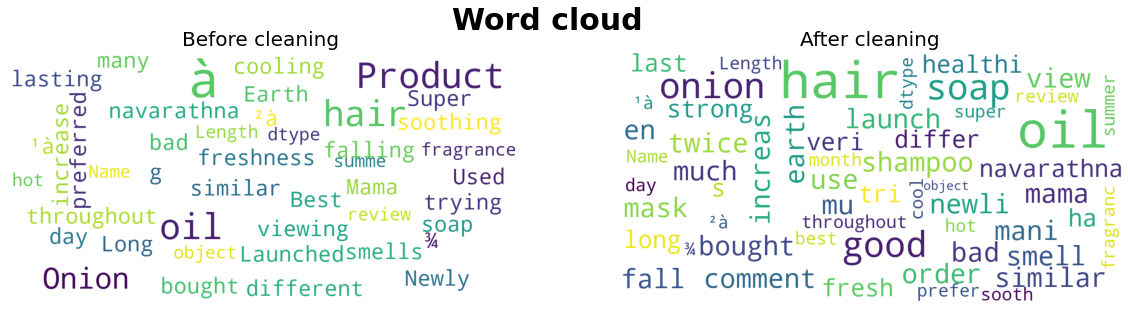

In [5]:
# dataCleaned, nanRemovedNb, nonWordsRemovedNb, stopWordsRemovedNb = wrangler(data, reviewColName)
X_y, nanFilter, nonWordFilter, stopWordFilter = wrangler(XRaw_y, reviewColName)
fig, axs = plt.subplots(1, 2, figsize = (20, 5)) 
fig.suptitle('Word cloud', fontsize= 30, fontweight='bold')
wordcloud_plotter(axs[0], XRaw_y[reviewColName], 'Before cleaning')
wordcloud_plotter(axs[1], X_y[reviewColName], 'After cleaning')
plt.savefig("../working/wordCloud.png")

## Results ([ToC](#TOC))<a class="anchor" id="TextWranglingResults"></a>

In [6]:
display_markdown('''
* Wrangling pipeline:
 1. Removing rows containing NA/NAN values;
 1. Removes non-word text tokens (HTML markup, emoticons, ...);
 1. Stem of text tokens;
 1. Removing stop-words text tokens.
* In total, the number of removed text tokens in each wrangling step is shown below:
 * | |Nb of non-NaN rows |Non-word filtering (nb of words)|Stop-word filtering (nb of words)|
   |:---|:---|:----|:----|
   |Before wrangling| **{0}**  | **{3}**| **{6}**|
   |After wrangling | **{1}**  | **{4}**| **{7}**|
   |Before - After          | **{2}**  | **{5}**| **{8}**|
'''.format(XRaw_y.shape[0], X_y.shape[0],XRaw_y.shape[0]-X_y.shape[0],
           nanFilter, nonWordFilter, nanFilter-nonWordFilter,
          nonWordFilter,stopWordFilter,nonWordFilter-stopWordFilter), raw=True) # .format(nanRemovedNb,nonWordsRemovedNb,stopWordsRemovedNb), raw=True)
del XRaw_y


* Wrangling pipeline:
 1. Removing rows containing NA/NAN values;
 1. Removes non-word text tokens (HTML markup, emoticons, ...);
 1. Stem of text tokens;
 1. Removing stop-words text tokens.
* In total, the number of removed text tokens in each wrangling step is shown below:
 * | |Nb of non-NaN rows |Non-word filtering (nb of words)|Stop-word filtering (nb of words)|
   |:---|:---|:----|:----|
   |Before wrangling| **2782**  | **112192**| **116542**|
   |After wrangling | **2778**  | **116542**| **64998**|
   |Before - After          | **4**  | **-4350**| **51544**|


# Train-test split ([ToC](#TOC))<a class="anchor" id="TrainTest"></a>
* To avoid [data leakage](https://www.kaggle.com/code/alexisbcook/data-leakage) and more specifically **Train-Test Contamination (TTC)**, the whole dataset is partitioned into the training and test dataset.
* TTC will lead to unreliable high performance with little generalisation to new unseen data, i.e., poor model performance when deploying it to make decisions with new unseen dataset.
* Test dataset segregation before any type of model fitting, e.g., data preprocessing or hyperparameters tuning, makes sure that the test set has never be seen in any step of the processing pipeline, hence the final model results on the test dataset will be more reliable.
* Notice that although the split has been done after text wrangling it doesn't cause TTC, because text wrangling doesn't involve any fitting of any kind, hence there are no fited model parameters that obtained from the training dataset to be applied on the test dataset.
* [sklearn.model_selection.train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) was used in a stratified manner, i.e., the initial whole dataset class size ratios are preserved in both training and test dataset, therefore both training and test datasets are good representatives of the initial dataset before splitting.

In [7]:
# dataCleaned, dataCleaned_test, _, _ = train_test_split(dataCleaned, dataCleaned[ratingColName], test_size=test_size,                                                     
#                                                     stratify = dataCleaned[ratingColName], # To make sure the splits & the whole data class proportions are roughly identical
#                                                     random_state=random_state) # train/test split
X, X_test, y, y_test = train_test_split(X_y[reviewColName], X_y[ratingColName], test_size=test_size,                                                     
                                                    stratify = X_y[ratingColName], # To make sure the splits & the whole data class proportions are roughly identical
                                                    random_state=random_state) # train/test split
del X_y, reviewColName, ratingColName

# N-class scenarios extraction ([ToC](#TOC))<a class="anchor" id="NClassScenarios"></a>


In [8]:
def class_chooser_helper(tmp, tmp2, clsNb = None):
    """A helper for class_chooser"""
    if clsNb != None:
        jj = clsNb
    elif clsNb == None:
        jj = range(2, len(tmp)+1)
    for j in jj:  
        tmp3 = list(combinations(tmp, j))
        for tmp4 in tmp3:
            tmp2.append(tmp4)
    return tmp2
  
    
def class_chooser(classLabel, clsNb = None):
    """Chooses possible combination of classes"""
    tmp2 = []
    tmp2 = class_chooser_helper(classLabel, tmp2, clsNb)
    for k in range(2,len(classLabel)):
        for i in range(0,len(classLabel)-k+1):
            tmp = []
            tmp.append((classLabel[i:i+k]))
            rest = set(classLabel)-set(classLabel[i:i+k])
            for tmp5 in rest:
                tmp.append(tmp5)
            tmp2 = class_chooser_helper(tmp, tmp2, clsNb)
    tmp2 = set(tmp2)
    classNb = defaultdict(list)
    for tmp in tmp2:
        classNb[len(tmp)].append(tmp)
    return classNb


def ismember(a, b): # https://devpress.csdn.net/python/630459aac67703293080ba45.html
    """Equivalent to MATLAB's ismember function"""
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = True
    return [bind.get(itm, False) for itm in a]  # None can be replaced by any other "not in b" value


# def class_merger(dataCleaned, ratingColName, classes):
def class_merger(X, y, classes):
    addVal = 100 
    flattenedClass = []
    for i in classes:
        if isinstance(i, (Sequence, np.ndarray)): # https://stackoverflow.com/questions/16807011/python-how-to-identify-if-a-variable-is-an-array-or-a-scalar
            for j in i:
                flattenedClass.append(j)
        else:
            flattenedClass.append(i)
    selectedClassesIdx = ismember(y, flattenedClass)
#     dataCleanedMerged = dataCleaned.loc[selectedClassesIdx, :]
#     print(len(y), len(selectedClassesIdx))
    if X.empty:
        XMerged = None
    else:
        XMerged = X.iloc[selectedClassesIdx]
    yMerged, yOrig = y.iloc[selectedClassesIdx], y.iloc[selectedClassesIdx]
#     dataCleanedMerged[ratingOrigColName] = dataCleaned[ratingColName]
#     yOrig = y.iloc[selectedClassesIdx]
#     print(yMerged)
    for newClass, oldClass in enumerate(classes):
#         yMerged = yMerged.replace({ratingColName:oldClass}, newClass + addVal)
#         yMerged = yMerged.replace({ratingOrigColName:oldClass}, str(oldClass))
        yMerged = yMerged.replace(oldClass, newClass + addVal)
        yOrig = yOrig.replace(oldClass, str(oldClass))
#     yMerged[ratingColName] -= addVal
    yMerged -= addVal
    return XMerged, yMerged, yOrig


def nRowCol_calculator(subplotsNb, subplotsCols = 5):
    if len(subplotsNb) > subplotsCols:
        nCol = subplotsCols
        nRow = math.ceil(len(subplotsNb) / nCol)
    else:
        nCol = len(subplotsNb)
        nRow = 1 
    return nRow, nCol


def plot_parameters(axs, pltIdx, nRow, nCol):
    rows, cols = divmod(pltIdx, nCol) # https://stackoverflow.com/questions/28995146/matlab-ind2sub-equivalent-in-python
    if nRow != 1:
            ax = axs[rows, cols]
    elif nCol != 1:
        ax = axs[cols]
    elif nCol == 1:
        ax = axs    
    if rows+1 == nRow:
        isXlabel = True
    else:
        isXlabel = False
    if cols+1 == 1:
        isYlabel = True
    else:
        isYlabel = False
    return ax, isXlabel, isYlabel


# # def classSize_plotter(ax, isXlabel, isYlabel, df, df_col, df_colOrig, colors_classes):
# def classSize_plotter(ax, isXlabel, isYlabel, y, yOrig, colors_classes):
#     df = pd.concat([y, yOrig], axis=1)
#     df.columns = ['y', 'yOrig']    
# #     sns.countplot(ax=ax, x = df_col, hue=df_colOrig, data = df, palette=colors_classes, dodge=False)
#     sns.countplot(ax=ax, x = 'y', hue='yOrig', data = df, palette=colors_classes, dodge=False)
#     if not isXlabel:
#         ax.set_xlabel('')
#     if not isYlabel:
#         ax.set_ylabel('')


def groupedBar_plotter(classes, classNbIdx, counts):
    """Grouped bar chart with labels
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html"""
#     species = ("Adelie", "Chinstrap", "Gentoo")
#     penguin_means = {
#         'Bill Depth': (18.35, 18.43, 14.98),
#         'Bill Length': (38.79, 48.83, 47.50),
#         'Flipper Length': (189.95, 195.82, 217.19),
#     }

    x = np.arange(len(classes))  # the label locations
    width = 0.24  # the width of the bars
    multiplier = 0

#     fig, ax = plt.subplots(constrained_layout=True)
    fig, ax = plt.subplots(figsize = (20, 4)) 
    fig.suptitle('Class size for {}-class classification task'.format(classNbIdx), fontsize= 30, fontweight='bold')
    plt.grid()
    ax.set_axisbelow(True)
    for attribute, measurement in counts.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Class size')
#     ax.set_title('Scenarios (original label merging)')
    ax.set_xticks(x + 0.5*width*(len(counts)-1), classes, rotation=30)
    ax.legend() # loc='upper left', ncols=3
    plt.show()
    plt.savefig("../working/{}-classSize.png".format(classNbIdx))


# def classSizeTot_plotter(classNb, classNbIdx, dataCleaned, ratingColName, colors_classes):
def classSizeTot_plotter(classNb, classNbIdx, y, colors_classes):
#     nRow, nCol = nRowCol_calculator(classNb[classNbIdx])    
#     fig, axs = plt.subplots(nRow, nCol, figsize = (20, 4*nRow)) 
#     fig.suptitle('Class size for {}-class classification task'.format(classNbIdx), fontsize= 30, fontweight='bold')
    counts = defaultdict(list)
    for pltIdx, classes in enumerate(classNb): # Scenarios
# #         dataCleanedMerged = class_merger(dataCleaned, ratingColName, classes)
        _, yMerged, yOrig = class_merger(pd.Series([]), y, classes) # No need to X
#         ax, isXlabel, isYlabel = plot_parameters(axs, pltIdx, nRow, nCol)
# #         classSize_plotter(ax, isXlabel, isYlabel, dataCleanedMerged, ratingColName, ratingOrigColName, colors_classes)
#         classSize_plotter(ax, isXlabel, isYlabel, yMerged, yOrig, colors_classes)
        for key, val in yMerged.value_counts().to_dict().items():
            counts[key].append(val)
#             print(key, val)
#     plt.savefig("../working/{}-classSize.png".format(classNbIdx))
    groupedBar_plotter(classNb, classNbIdx, counts)
    

def scenario_counter(classNb):
    scenarioNb = []
    for val in classNb.values():
        scenarioNb.append(len(val))
    return scenarioNb

## Class count plot per N-class scenarios ([ToC](#TOC))<a class="anchor" id="ClassCountPlot"></a>
* As it can be seen in the next figure, in some scenarios the number of observations per class can be highly imbalanced/skewed, which can lead to unreliable results if it is not treated.
* [Imbalanced-learn](https://imbalanced-learn.org/stable/) is a scikit-learn-based library that provides some useful tools (among which [SMOTE](https://www.jair.org/index.php/jair/article/view/10302) is selected here in the processing pipeline) to deal with imbalanced datasets. 

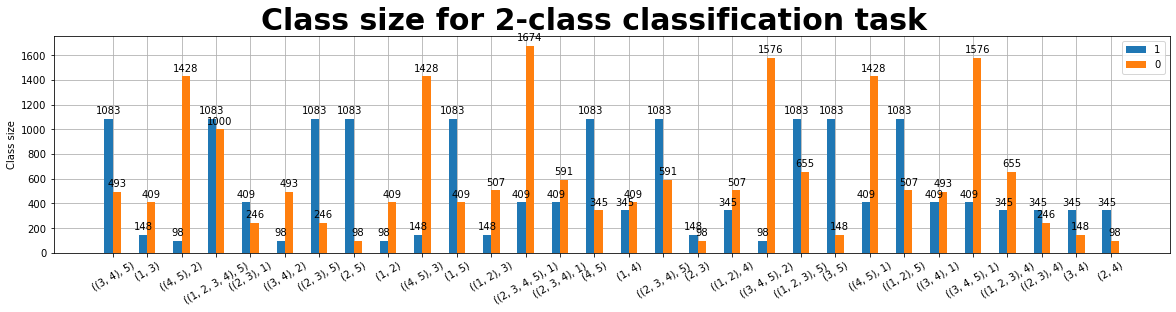

<Figure size 432x288 with 0 Axes>

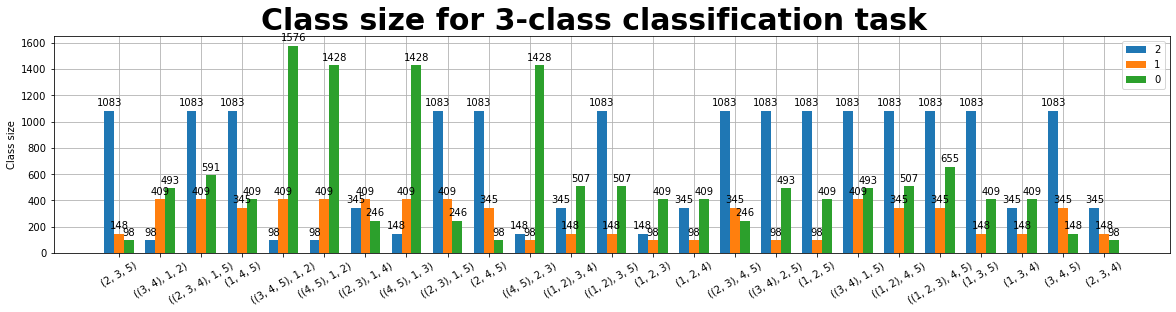

<Figure size 432x288 with 0 Axes>

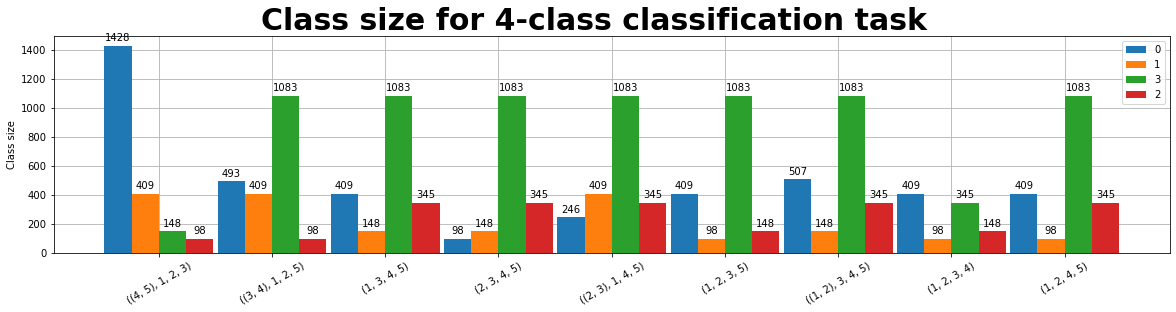

<Figure size 432x288 with 0 Axes>

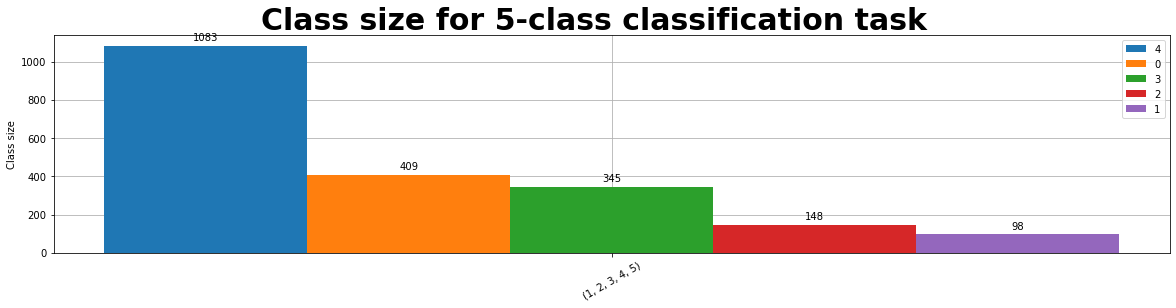

<Figure size 432x288 with 0 Axes>

In [9]:
colors_classes = sns.color_palette()
# classLabel = tuple(np.unique(dataCleaned[ratingColName]))
classLabel = tuple(np.unique(y))
classNb = class_chooser(classLabel, clsNb = None) # Specify clsNb=None, for general case [4, 5]
nClass = list(classNb.keys())
scenarioNb = scenario_counter(classNb)
for classNbIdx in classNb.keys():
#     classSizeTot_plotter(classNb, classNbIdx, dataCleaned, ratingColName, colors_classes)
#     classSizeTot_plotter(classNb, classNbIdx, y, colors_classes)
    classSizeTot_plotter(classNb[classNbIdx], classNbIdx, y, colors_classes)

## Results ([ToC](#TOC))<a class="anchor" id="NClassScenariosResults"></a>

In [10]:
display_markdown('''
* For each total number of N classes, i.e., 2, 3, 4, and 5, all possible N selection of classes from the original number of classes (5) has been considered:
 * E.g., for N = 3 selection out of 5, some 3-class scenarios are:
      * [1, 2, 3], 
      * [1, 2, 4], 
      * [1, 2, 5], ...
* Also all possible merging of **neighboring** classes are considered:
 * E.g., for N = 3, some merged 3-class scenarios are (merged classes are enclosed in parentheses):
     * [(1,2), 3, 4], 
     * [1, (2,3), 4], 
     * [1, 2, (3,4)],
     * [(1,2,3), 4, 5],
     * [1,(2,3,4), 5],
     * [1, 2, (3,4,5)].
* In total, with 5 initial classes there are the following number of N-class scenarios per N:
 * | N-class |Nb of scenarios|
   |:---|----:|
   | **{0}**  | **{4}**|
   | **{1}**  | **{5}**|
   | **{2}**  | **{6}**|
   | **{3}**  | **{7}**|
'''.format(nClass[0],nClass[1],nClass[2],nClass[3],
          scenarioNb[0], scenarioNb[1], scenarioNb[2], scenarioNb[3]), raw=True)


* For each total number of N classes, i.e., 2, 3, 4, and 5, all possible N selection of classes from the original number of classes (5) has been considered:
 * E.g., for N = 3 selection out of 5, some 3-class scenarios are:
      * [1, 2, 3], 
      * [1, 2, 4], 
      * [1, 2, 5], ...
* Also all possible merging of **neighboring** classes are considered:
 * E.g., for N = 3, some merged 3-class scenarios are (merged classes are enclosed in parentheses):
     * [(1,2), 3, 4], 
     * [1, (2,3), 4], 
     * [1, 2, (3,4)],
     * [(1,2,3), 4, 5],
     * [1,(2,3,4), 5],
     * [1, 2, (3,4,5)].
* In total, with 5 initial classes there are the following number of N-class scenarios per N:
 * | N-class |Nb of scenarios|
   |:---|----:|
   | **2**  | **30**|
   | **3**  | **25**|
   | **4**  | **9**|
   | **5**  | **1**|


# Fine-tuned optimal classifier using GridSearchCV ([ToC](#TOC))<a class="anchor" id="optimalClassifier"></a>
* Exhaustive Grid Search ([sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV))
* Classifiers:
 * [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html):
     * “naive”/"idiot" assumption: conditional independence between every pair of features given the value of the class variable:
         * curse of dimensionality-related problems are alleviated, because each feature distribution can be independently and individually (1D feature space) estimated
     * Maximum A Posteriori (MAP) estimation to estimate class label;
     * [It works quite well in many real-world situations: document classification, spam filtering](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf);
     * A small amount of training data is required
     * Extremely fast compared to more sophisticated methods
     * The probability outputs from predict_proba() are not reliable, so cannot be interpreted as a confidence level ([bad estimator](https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py)).
     * Variants:
         * Gaussian Naive Bayes ([sklearn.naive_bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)):
             * The likelihood of the features is assumed to be Gaussian;
             * The Gaussian parameters are estimated using maximum likelihood.
         * Multinomial Naive Bayes ([sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB))
             * The likelihood of the features is assumed to be multinomial;
             * Suitable for classification with discrete features (e.g., word counts for text classification), but in practice fractional counts such as tf-idf may also work.
             * The multinomial parameters are estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting.
             
             
             
([sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC))

([sklearn.gaussian_process.GaussianProcessClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier))

([sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier))

([sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier))

([sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier))
     
([sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis))

In [11]:
def tfidf_instantiator(): 
    TfidfVectorizerParams = {'sublinear_tf':True, 'strip_accents':None, 'lowercase':False, 'preprocessor':None} # To meke sure the same TfidfVectorizer params are used across the code
    tfidf  = TfidfVectorizer(**TfidfVectorizerParams) 
    return tfidf


def smote_instantiator(y): 
    """SMOTE value is equal to the maximum class size"""
    smoteClassSize = pd.Series(np.asarray(y)).value_counts(sort=True).iloc[0] # The resulting object will be in descending order so that the first element is the most frequently-occurring element.
    sampling_strategy = {}
    for i in np.unique(y):
        sampling_strategy[i] = smoteClassSize
    smote = SMOTE(random_state=random_state, sampling_strategy=sampling_strategy ) #  , k_neighbors = 3
    return smote


def clf_instantiator(clfName):     
    if clfName == "svm":
        clf = svm.SVC(probability=True, random_state=random_state) 
        param_grid = [{clfParamName+'__'+'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # linear
                           clfParamName+'__'+'C': [50, 10, 1.0, 0.1, 0.01],
                           clfParamName+'__'+'gamma': ['scale', 'auto']}]
    elif clfName == "knn":
        clf = KNeighborsClassifier() 
        param_grid = [{clfParamName+'__'+'n_neighbors': range(1, 5, 2)}]#, range(1, 21, 2)
#                            clfParamName+'__'+'weights': ['uniform', 'distance'],
#                            clfParamName+'__'+'metric': ['euclidean', 'manhattan', 'minkowski', 'canberra']}]
    elif clfName == "lr":
        clf = LogisticRegression(random_state=random_state) 
        param_grid = [{clfParamName+'__'+'solver': ['lbfgs'], # ['lbfgs', 'newton-cg', 'liblinear']
            clfParamName+'__'+'penalty': ['l2'], # ['l1', 'l2']
                       clfParamName+'__'+'C': [0.001, 0.01]}] # [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    elif clfName == "ridge":
        clf = RidgeClassifier(random_state=random_state) 
        param_grid = [{clfParamName+'__'+'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}] 
    elif clfName == "gp":
        clf = GaussianProcessClassifier(random_state=random_state) 
        param_grid = "?"
    elif clfName == "gnb":
        clf = GaussianNB() 
        param_grid = "?"     
    elif clfName == "mnb":
        clf = MultinomialNB() 
        param_grid = "?"             
    elif clfName == "dt":
        clf = DecisionTreeClassifier(random_state=random_state)        
        param_grid = [{clfParamName+'__'+'max_features': ['sqrt', 'log2']+list(range(0,14)),
                      clfParamName+'__'+'max_depth': list(range(10,15))}] 
    elif clfName == "bagging":
        clf = BaggingClassifier(random_state=random_state) 
        param_grid = [{clfParamName+'__'+'n_estimators': [10, 100, 1000]}] 
    elif clfName == "rforest":
        clf = RandomForestClassifier(random_state=random_state) 
        param_grid = [{clfParamName+'__'+'n_estimators': [10, 100, 1000],
                      clfParamName+'__'+'max_features': ['sqrt', 'log2']+list(range(0,14)),
                      clfParamName+'__'+'max_depth': list(range(10,15))}] 
    elif clfName == "gbm":
        clf = GradientBoostingClassifier(random_state=random_state) 
        param_grid = [{clfParamName+'__'+'n_estimators': [10, 100, 1000],
                      clfParamName+'__'+'learning_rate': [0.001, 0.01, 0.1],
                      clfParamName+'__'+'subsample': [0.5, 0.7, 1.0],
                      clfParamName+'__'+'max_depth': [3, 7, 9]}]
    elif clfName == "mlp":
        clf = MLPClassifier(random_state=random_state) 
        param_grid = "?"
    return clf, param_grid


def model_builder(y, clfName, clfParamName):    
    tfidf = tfidf_instantiator()        
    smote = smote_instantiator(y)
    if type(clfName) == str: # Grid-search mode: instantiate clf
        clf, param = clf_instantiator(clfName)
    else: # uses previously-computed optimal clf
        clf, param = clfName, None
    model = Pipeline([('tfidf', tfidf), (clfParamName, clf)]) # , ('smote', smote)
    return model, param


def params_counter(param):
    paramCount = 1
    for val in param[0].values():
        paramCount *= len(val)
    return paramCount
 

def optClf_finder(clfNames, X, y):
    """Finds optimal clf and related params using gridSearchCV"""
    gridSearchCV = {}
    clfParamNb = {}
    for clfName in clfNames:
        model, param = model_builder(y, clfName, clfParamName)
        clfParamNb[clfName] = params_counter(param)
        gs = GridSearchCV(model, param, scoring='accuracy', cv=n_splits, verbose=2, n_jobs=-1)
        gs.fit(X, y)
        gridSearchCV[clfName] = [gs.best_params_, gs.best_score_]
        print('Best parameter set: {}'.format(gs.best_params_))
        print('CV Accuracy: {}'.format(gs.best_score_))
    acc = []
    for val in gridSearchCV.values():
        acc.append(val[1])
    optClfAcc = np.max(acc)
    optClfName = clfNames[np.argmax(acc)] # Index of classifier with maximum performance in grid search
    optParam = gridSearchCV[optClfName][0]
    optParam2 = {}
    for key, val in optParam.items():
        optParam2[key[len(clfParamName)+2:]] = val
    optClf, _ = clf_instantiator(optClfName) # instantiate the optimal clf
    optClf.set_params(**optParam2) # set the optimal params
    print('optimal clf is {}.'.format(optClfName))
    clear_output(wait=False)
    return optClf, optClfName, optClfAcc, clfParamNb


def gridSearch_plotter(optClasses, optClfsName, optClfsAcc, classNbIdx):
    xtickLabel = []
    for i, j in zip(optClasses, optClfsName):
        xtickLabel.append(str(i) + '-' + j)  
    sorteds = list(zip(xtickLabel, optClfsAcc)) # sort acc
    sorteds.sort(key = lambda x: x[1])
    xtickLabel, optClfsAcc = list(zip(*sorteds))[0], list(zip(*sorteds))[1]
    fig, _ = plt.subplots(1, 1, figsize = (20, 4)) 
    fig.suptitle('Grid search accuracy (cv={}) for {}-class classification tasks'.format(n_splits, classNbIdx), fontsize= 30, fontweight='bold')
#     plt.plot(optClfsAcc, 'o-')
    plt.stem(optClfsAcc)
    plt.xticks(np.arange(len(optClfsAcc)), xtickLabel, rotation=30)
    plt.ylabel('Accuracy')
    plt.xlabel('Optimum classifier per class merging')
    plt.grid()
    plt.savefig("../working/{}-GridSearchAcc.png".format(classNbIdx)) 

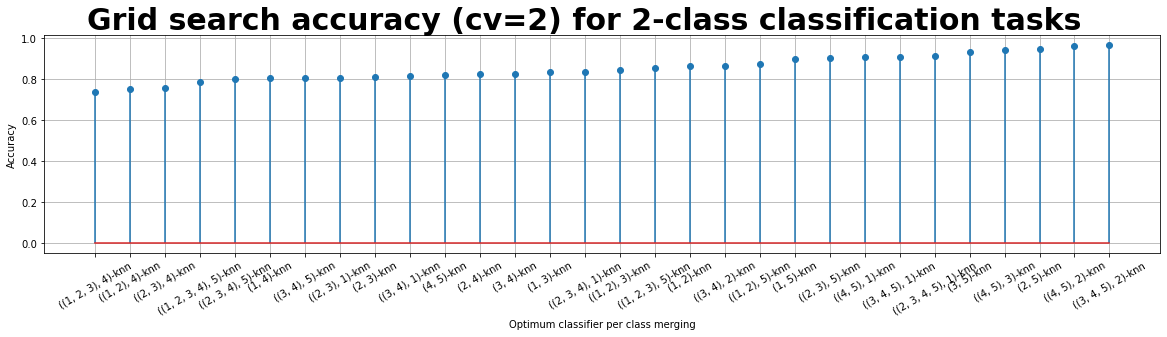

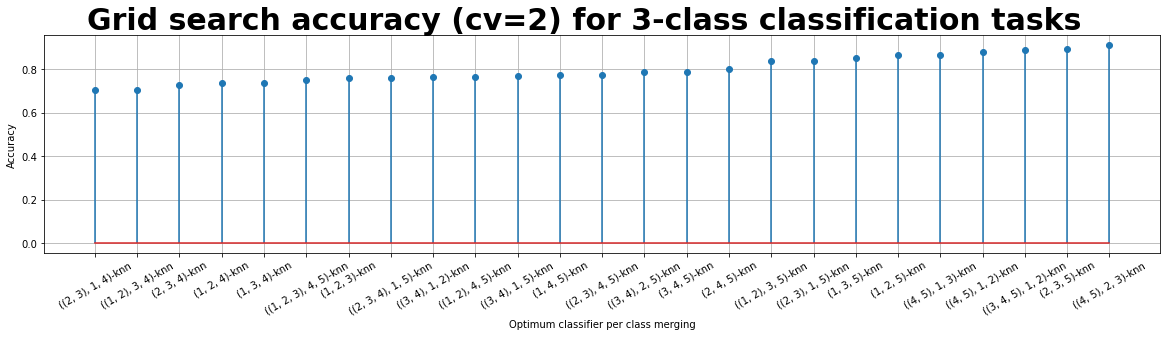

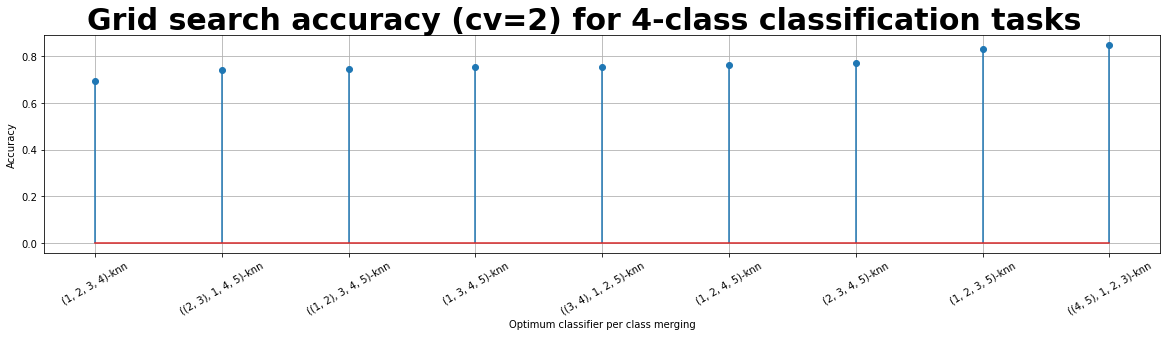

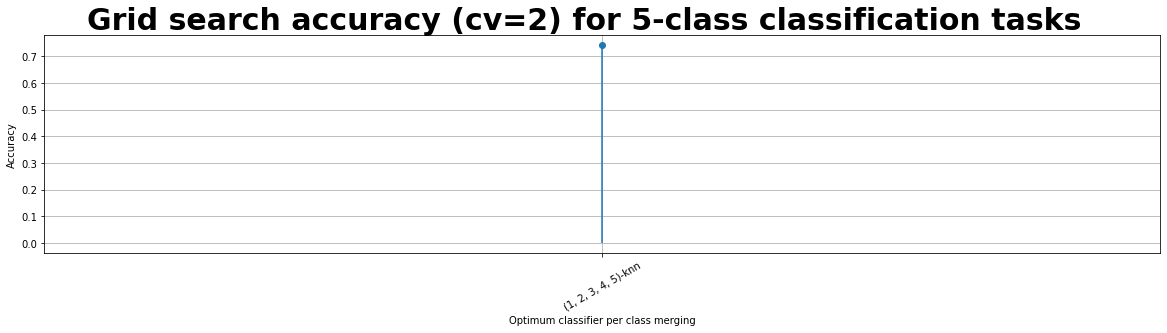

In [12]:
clfNames = ['knn'] # ['svm', 'ridge', 'bagging', 'rforest', 'gbm', 'knn', 'lr']
optClfs = defaultdict(list)
optClfsName = defaultdict(list)
optClasses = defaultdict(list)
optClfsAcc = defaultdict(list)
dataCleanedMerged = defaultdict(list)
for classNbIdx in classNb.keys(): # N-classes
    for classes in classNb[classNbIdx]: # Scenarios
#         dataMerged = class_merger(dataCleaned, ratingColName, classes)
        XMergedTmp, yMergedTmp, yMergedOrigTmp = class_merger(X, y, classes)
#         dataCleanedMerged[classNbIdx].append(dataMerged)
        dataCleanedMerged[classNbIdx].append((XMergedTmp, yMergedTmp, yMergedOrigTmp))
#         optClf, optClfName, optClfAcc, clfParamNb = optClf_finder(clfNames, dataMerged[reviewColName], dataMerged[ratingColName])
        optClf, optClfName, optClfAcc, clfParamNb = optClf_finder(clfNames, XMergedTmp, yMergedTmp)
        optClfs[classNbIdx].append(optClf)
        optClfsName[classNbIdx].append(optClfName)
        optClasses[classNbIdx].append(classes)
        optClfsAcc[classNbIdx].append(optClfAcc)  
optDataCleanedMerged = []
optClf = []
optClfName = []
optClass = []
optClfAcc = []
# dataCleanedMerged_test = []
yMerged_test = []
for classNbIdx in classNb.keys():   
    gridSearch_plotter(optClasses[classNbIdx], optClfsName[classNbIdx], optClfsAcc[classNbIdx], classNbIdx)    
    optIdx = np.argmax(optClfsAcc[classNbIdx]) # Maximum acc idx across different combinations of the classNbIdx-class classification task
    optDataCleanedMerged.append(dataCleanedMerged[classNbIdx][optIdx])
    optClf.append(optClfs[classNbIdx][optIdx])
    optClfName.append(optClfsName[classNbIdx][optIdx])
    optClass.append(optClasses[classNbIdx][optIdx])
    optClfAcc.append(optClfsAcc[classNbIdx][optIdx])    
#     dataCleanedMerged_test.append(class_merger(dataCleaned_test, ratingColName, optClasses[classNbIdx][optIdx])) # Merge test labels based on the optimal merging
    yMerged_test.append((class_merger(X_test, y_test, optClasses[classNbIdx][optIdx]))) # Merge test labels based on the optimal merging
clear_output(wait=False)
del dataCleanedMerged, optClfs, optClfsName, optClasses, optClfsAcc, optIdx

## GridSearchCV accuracy comparison across multi-class, i.e., 2-class, ..., 5-class, scenarios ([ToC](#TOC))<a class="anchor" id="optimalScenario"></a>

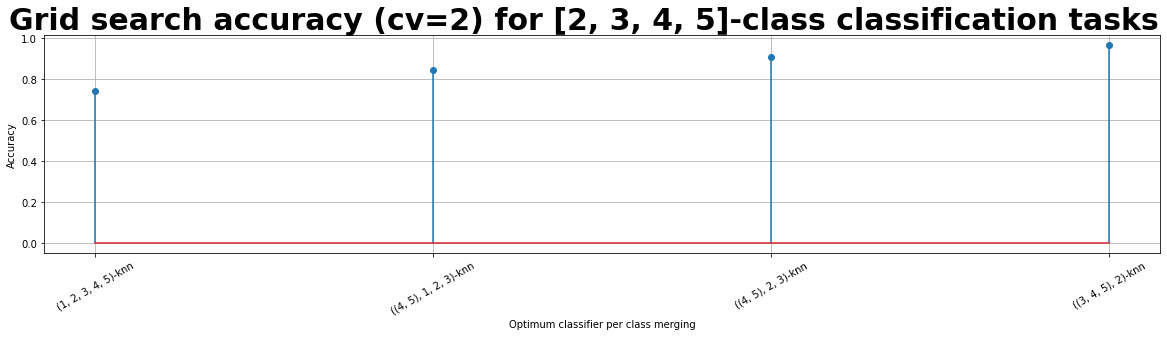

In [13]:
gridSearch_plotter(optClass, optClfName, optClfAcc, str(list(classNb.keys())))

## Results ([ToC](#TOC))<a class="anchor" id="optimalClassifierResults"></a>

In [14]:
tmp1 = ('').join(["|"]*len(clfParamNb))
tmp2 = ('').join([":---|"]*len(clfParamNb))
tmp3 = []
for keys in clfParamNb.keys():
    tmp3.append(keys+'|')
tmp3 = ('').join(tmp3)
tmp4 = []
for val in clfParamNb.values():
    tmp4.append(str(val)+'|')
tmp4 = ('').join(tmp4)
display_markdown('''
* For each N-class classification task, i.e., 2-class, ..., 5-class, and its scenarios the following procedure is repeated:
    1. Model (pipeline: TF-IDF -> SMOTE -> classifier) is built;
    1. GridSearchCV is applied on the follwong classifiers to find their optimal hyper-parameters:
     * ||{}
       |:---|{}
       |**Classifier**|{}
       |**Nb of serached hyperparameters**|{}
    1. The optimal classifier among the above fine-tuned ones maximising the average cross validation accuracy is selected.
* Then, for each N-class classification task, i.e., 2-class, ..., 5-class, the optimal scenario with maximum average cross validation accuracy is selected, as shown below:
 * | |**{}-class**|**{}-class**| **{}-class**| **{}-class**|
   |:---|:---|:----|:----|:----|
   |**Nb of scenarios**|{}|{}|{}|{}|
   |**Opt. scenario**|{}|{}|{}|{}|
   |**Opt. classifier**|{}|{}|{}|{}|
   |**GridSearchCV ACC**|{}|{}|{}|{}|
'''.format(tmp1,tmp2,tmp3, tmp4, 
           *nClass, *scenarioNb, *optClass, *optClf, *[round(acc_, 2) for acc_ in optClfAcc]), raw=True)


* For each N-class classification task, i.e., 2-class, ..., 5-class, and its scenarios the following procedure is repeated:
    1. Model (pipeline: TF-IDF -> SMOTE -> classifier) is built;
    1. GridSearchCV is applied on the follwong classifiers to find their optimal hyper-parameters:
     * |||
       |:---|:---|
       |**Classifier**|knn|
       |**Nb of serached hyperparameters**|2|
    1. The optimal classifier among the above fine-tuned ones maximising the average cross validation accuracy is selected.
* Then, for each N-class classification task, i.e., 2-class, ..., 5-class, the optimal scenario with maximum average cross validation accuracy is selected, as shown below:
 * | |**2-class**|**3-class**| **4-class**| **5-class**|
   |:---|:---|:----|:----|:----|
   |**Nb of scenarios**|30|25|9|1|
   |**Opt. scenario**|((3, 4, 5), 2)|((4, 5), 2, 3)|((4, 5), 1, 2, 3)|(1, 2, 3, 4, 5)|
   |**Opt. classifier**|KNeighborsClassifier(n_neighbors=1)|KNeighborsClassifier(n_neighbors=1)|KNeighborsClassifier(n_neighbors=1)|KNeighborsClassifier(n_neighbors=1)|
   |**GridSearchCV ACC**|0.97|0.91|0.85|0.74|


# Receiver Operating Characteristic ([ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curves ([ToC](#TOC))<a class="anchor" id="ROC"></a>

In [15]:
# def output_binariser(X, Y, classLabel):
#     """Binarize the output"""
#     if len(classLabel) == 2:
#         addedLabel = classLabel[-1]+1       
#         classes = classLabel.copy()
#         classes.append(addedLabel)
#         y_binary = label_binarize(Y, classes=classes)
#         y_binary = y_binary[:,:-1]
#     else:
#         y_binary = label_binarize(Y, classes=classLabel)
#     X_binary, Y_binary = [], []
#     for i in range(y_binary.shape[1]): 
#         Xrsmp, Yrsmp = X, y_binary[:, i]
#         X_binary.append(Xrsmp)
#         Y_binary.append(Yrsmp)
#     return X_binary, Y_binary


class MyLabelBinarizer(LabelBinarizer): # https://stackoverflow.com/questions/31947140/sklearn-labelbinarizer-returns-vector-when-there-are-2-classes
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
        
        
def idx_finder_micro(classNb):
    idx = []
    for i in range(n_repeats*n_splits):
        idx.append(np.asarray(list(range((classNb-1)*X_test.shape[0], classNb*X_test.shape[0]))) + i * (n_classes-1)*X_test.shape[0])
    idx = np.hstack(idx)
    return idx


def fpr_unique_finder(n_classes, classNb, fpr_all):
    idx = list(range((classNb-1), n_classes * n_repeats*n_splits, n_classes))
    fprSel = []
#     print(idx)
    for i in idx:
        fprSel.append(fpr_all[i])
    fprUnique = np.unique(np.concatenate(np.asarray(fprSel)))
    return fprUnique


def microAvg_calc(n_classes, y_test_all_ravel, y_score_all):
    # Compute micro-average ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()    
    for i in range(n_classes):
        micro_tmp = "micro_{}".format(i+1)
        fpr[micro_tmp], tpr[micro_tmp], _ = roc_curve(y_test_all_ravel[idx_finder_micro(i+1)], y_score_all[idx_finder_micro(i+1)])
        roc_auc[micro_tmp] = auc(fpr[micro_tmp], tpr[micro_tmp])  
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_all_ravel, y_score_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc


def roc_bestThr(tpr, fpr, thr, fieldName):
#     https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    roc_auc = {}
    gmeans = np.sqrt(tpr * (1-fpr)) # calculate the g-mean for each threshold
    roc_auc["{}BestThrIdx".format(fieldName)] = np.argmax(gmeans) # locate the index of the largest g-mean
    roc_auc["{}BestThrVal".format(fieldName)] = thr[roc_auc["{}BestThrIdx".format(fieldName)]] 
    roc_auc["{}BestThrGmeans".format(fieldName)] = gmeans[roc_auc["{}BestThrIdx".format(fieldName)]]
    return roc_auc


def macroAvg_calc(n_classes, n_repeats, n_splits, fpr_all, fpr, tpr, thresholds): 
    """ROC curves for different classes are interpolated at the same grid points, 
    so then the average across repetitions (cross-validation and/or classes) 
    can be computed which is called Macro-average
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html"""
    # First aggregate all false positive rates
#     fpr_unique_perClass = []
#     for i in range(n_classes):
# #         fpr_unique_perClass.append(fpr_unique_finder(n_classes, i+1, fpr_all))  
#         fpr_unique_perClass.append(np.linspace(0.0, 1.0, 1000))  
# #     fpr_unique = np.unique(np.concatenate(fpr_all))
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr_perClass = {}
    mean_thr_perClass = {}
    for j in range(n_classes):
#         mean_tpr_perClass[j] = np.zeros_like(fpr_unique_perClass[j])
#         mean_thr_perClass[j] = np.zeros_like(fpr_unique_perClass[j])
        mean_tpr_perClass[j] = np.zeros_like(fpr_grid)
        mean_thr_perClass[j] = np.zeros_like(fpr_grid)
    mean_tpr = np.zeros_like(fpr_grid)
    mean_thr = np.zeros_like(fpr_grid)
    for i in range(n_classes):
        for j in range(n_repeats*n_splits):
            mean_tpr += np.interp(fpr_grid, fpr[i][j], tpr[i][j])
#             mean_tpr_perClass[i] += interp(fpr_unique_perClass[i], fpr[i][j], tpr[i][j])
            mean_tpr_perClass[i] += np.interp(fpr_grid, fpr[i][j], tpr[i][j])
            mean_thr += np.interp(fpr_grid, fpr[i][j], thresholds[i][j])
            mean_thr_perClass[i] += np.interp(fpr_grid, fpr[i][j], thresholds[i][j])
#             mean_thr_perClass[i] += interp(fpr_unique_perClass[i], fpr[i][j], thresholds[i][j])
    # Finally average it and compute AUC
    mean_tpr /= (n_classes * n_repeats*n_splits)
    mean_thr /= (n_classes * n_repeats*n_splits)
    for i in range(n_classes):
        mean_tpr_perClass[i] /= (n_repeats*n_splits)
        mean_thr_perClass[i] /= (n_repeats*n_splits)

    roc_auc = dict()
    for i in range(n_classes):
        macro_tmp = "macro_{}".format(i+1)      
        fpr[macro_tmp], tpr[macro_tmp] = fpr_grid, mean_tpr_perClass[i]
#         fpr[macro_tmp], tpr[macro_tmp] = np.hstack([0, fpr_unique_perClass[i], 1]), np.hstack([0, mean_tpr_perClass[i], 1])
        
        roc_auc_ = roc_bestThr(tpr[macro_tmp], fpr[macro_tmp], mean_thr_perClass[i], macro_tmp)
        roc_auc.update(roc_auc_)
    
        roc_auc[macro_tmp] = auc(fpr[macro_tmp], tpr[macro_tmp])

    fpr["macro"], tpr["macro"] = fpr_grid, mean_tpr
    roc_auc_ = roc_bestThr(tpr["macro"], fpr["macro"], mean_thr, "macro")
    roc_auc.update(roc_auc_)
    
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])                                 
    return fpr, tpr, roc_auc


def split_feature_clf_cv(X, y, clf, n_splits, n_repeats):
    """Splits into train/test; extracts features; trains & tests the classifier using N*K-fold cross-validation. Returns average test accuracy."""
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state) 
    acc, fpr, tpr, thr, auc_, y_testTot, y_scoreTot = [], [], [], [], [], [], []
    for train_index, test_index in cv.split(X, y): # 0<k<(n_repeats*n_splits-1)
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index] # train/test split
#         if len(np.unique(y)) == 2: # If binary task  
#             print(np.shape(y_test))
        model, _ = model_builder(y_train, clf, '')
        model.fit(X_train, y_train)                 
        if len(np.unique(y)) == 2: # If binary task  
            y_score = model.predict_proba(X_test)[:, 1]
#             print(np.shape(y_score))
            fpr_, tpr_, thr_ = roc_curve(y_test, y_score) 
#             print(np.shape(y_test), np.shape(y_score))
#             print(np.shape(fpr_))
            auc__ = auc(fpr_, tpr_)
        else:
            fpr_, tpr_, thr_, auc__, y_score = np.nan, np.nan, np.nan, np.nan, np.nan
        acc.append(model.score(X_test, y_test)) # Classifier acc         
        fpr.append(fpr_)
        tpr.append(tpr_)
        thr.append(thr_)
        auc_.append(auc__)
        y_testTot.append(y_test)
        y_scoreTot.append(y_score)
#         if len(np.unique(y)) == 2: # If binary task  
#             print(np.shape(y_testTot), np.shape(y_scoreTot))
    y_testTot, y_scoreTot = np.hstack(y_testTot), np.hstack(y_scoreTot)
#     print(np.shape(y_testTot), np.shape(y_scoreTot))
#     tmp =np.hstack(fpr)
#     print(np.shape(tmp))
    return acc, fpr, tpr, thr, auc_, y_testTot, y_scoreTot


def negClass_finder(classLabel, classLabelTot, origNew):
    theRest = list(set(classLabelTot) - set([classLabel]))
    theRestTot = []
    for i in theRest:
        theRestTot.append(origNew[i])
    return ','.join(theRestTot)


def rocRpt_plotter(ax, classLabelTot, fpr, fprMacro, tpr, tprMacro, aucMacro, 
                   aucBestThrIdx, aucBestThrGMean, color, lw, classLabel, isYlabel, origNew, ylabel):
    for j in range(len(fpr)): 
        if j == 1:
            ax.plot(fpr[j], tpr[j], color=color, lw=lw, label='Classes {}'.format(origNew[classLabel]), alpha=1) # 
        ax.plot(fpr[j], tpr[j], color=color, lw=lw) # , alpha=0.5

    ax.plot(fprMacro, tprMacro, 'k', lw=2*lw, label='Macro-avg (AUC = {0:0.2f})'
                 .format(aucMacro))
    ax.scatter(fprMacro[aucBestThrIdx], tprMacro[aucBestThrIdx], marker='o', color='k', s=2**7, zorder=20,
                    label='Opt (GM = {0:0.2f})'.format(aucBestThrGMean))  
    theRestTot = negClass_finder(classLabel, classLabelTot, origNew)
    rocAxis_plotter(ax, lw, ylabel, "Pos. label : {} \n Neg. labels : {}".format(origNew[classLabel], theRestTot))


def rocAxis_plotter(ax, lw, ylabel=None, title=None):
    ax.axis('square')
    ax.plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
    ax.axis([-0.05, 1.0, 0.0, 1.05])
    ax.set_ylabel(ylabel, fontsize=12)  
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
    ax.set_title (title, fontdict = {'size':12}) # , pad = 20 
    ax.legend(loc="lower right")
    ax.grid() 
    
    
def origNewLabel_finder(origLabel, newLabel): 
    newLabelUnique = np.unique(newLabel)
    origNew = {}
    for i in newLabelUnique:
        origNew[i]= origLabel[newLabel == i][0]
    return origNew
    
    
# def rocTot_plotter(optDataCleanedMerged, reviewColName, ratingColName, ratingOrigColName, clfName, clf, lw, colors_classes):
def rocTot_plotter(optDataCleanedMerged, clfName, clf, lw, colors_classes):    
#     YOrig = optDataCleanedMerged[ratingOrigColName].values
#     X = optDataCleanedMerged[reviewColName].values
#     y = optDataCleanedMerged[ratingColName].values
    YOrig = optDataCleanedMerged[2].values
    X = optDataCleanedMerged[0].values
    y = optDataCleanedMerged[1].values
#     print(y)
#     return
    origNew = origNewLabel_finder(YOrig, y)
    classLabel = list(np.unique(y))   
    
#     X_binary, Y_binary = output_binariser(X, y, classLabel)
    Y_binary = MyLabelBinarizer().fit_transform(y)
#     print(range(Y_binary.shape[1]))
#     return

    n_classes = len(classLabel)  
    fig, ax = plt.subplots(1, n_classes+1, figsize=(20,5), sharey=True, sharex=True)
    fig.suptitle('ROC ({}-class; {}*{}-fold cross-validation)'.format(n_classes, n_repeats, n_splits), #  performance evaluation technique
                fontsize=20, fontweight='bold')          
    fpr_models = [] #dict()
    acc, fpr, tpr, thr, auc_ = {}, {}, {}, {}, {}
    y_testTot, y_scoreTot, fprTot = [], [], []
#     for i, (X, y) in enumerate(zip(X_binary, Y_binary)):
    for i in range(Y_binary.shape[1]): # ovr cases: fpr/tpr/thr[pos. class][repetitions] --- acc/auc[pos. class]: repetitions
#         acc[i], fpr[i], tpr[i], thr[i], auc_[i], y_testTot_, y_scoreTot_ = split_feature_clf_cv(X, y, clf, n_splits, n_repeats)
        acc[i], fpr[i], tpr[i], thr[i], auc_[i], y_testTot_, y_scoreTot_ = split_feature_clf_cv(X, Y_binary[:, i], clf, n_splits, n_repeats)
        y_testTot.append(y_testTot_)
        y_scoreTot.append(y_scoreTot_)
        fprTot.append(fpr[i])
#         print((fpr[i][0]))
#         print((np.shape(acc[0])))
#     return
#     print((np.shape(fprTot)))
    y_testTot, y_scoreTot = np.hstack(y_testTot), np.hstack(y_scoreTot)
    if np.ndim(fprTot) == 2:  # Added items to the list have been of different lengths
        fprTot = np.hstack(fprTot)
    elif np.ndim(fprTot) == 3: # Added items to the list have been of the sale length
        fprTot = np.vstack(fprTot)
#     print((np.shape(fprTot)))
#     return
    fpr_macro, tpr_macro, roc_auc_macro = macroAvg_calc(n_classes, n_repeats, n_splits, fprTot, fpr, tpr, thr)                            
    fpr.update(fpr_macro)
    tpr.update(tpr_macro)
    auc_.update(roc_auc_macro)

    for i in range(n_classes):
        if i == 0:
            ylabel = '{} \n True Positive Rate (TPR)'.format(clfName)
        else:
            ylabel = None
        rocRpt_plotter(ax[i], classLabel, fpr[i], fpr["macro_{}".format(i+1)], tpr[i], tpr["macro_{}".format(i+1)], auc_["macro_{}".format(i+1)], 
        auc_["macro_{}BestThrIdx".format(i+1)], auc_["macro_{}BestThrGmeans".format(i+1)], 
                       colors_classes[i], lw, classLabel[i], i==0, origNew, ylabel)
    for i in range(n_classes):
        ax[n_classes].plot(fpr["macro_{}".format(i+1)], tpr["macro_{}".format(i+1)],color= colors_classes[i], lw=2*lw, 
                   label='Class {0} (AUC = {1:0.2f})'.format(origNew[classLabel[i]], auc_["macro_{}".format(i+1)]))        
    ax[n_classes].plot(fpr["macro"], tpr["macro"], 'k', lw=2*lw, label='Macro-avg (AUC = {0:0.2f})'.format(auc_["macro"]))
    ax[n_classes].scatter(fpr["macro"][auc_["macroBestThrIdx"]], 
                         tpr["macro"][auc_["macroBestThrIdx"]], 
                         marker='o', color='k', s=2**7, zorder=20,
                            label='Opt (GM = {0:0.2f})'.format(auc_["macroBestThrGmeans"]))
    rocAxis_plotter(ax[n_classes], lw, ylabel=None, title='Across classes')
    fpr_models = fpr, tpr, auc_
    plt.savefig("../working/{}-classROC.png".format(n_classes))
    return fpr_models

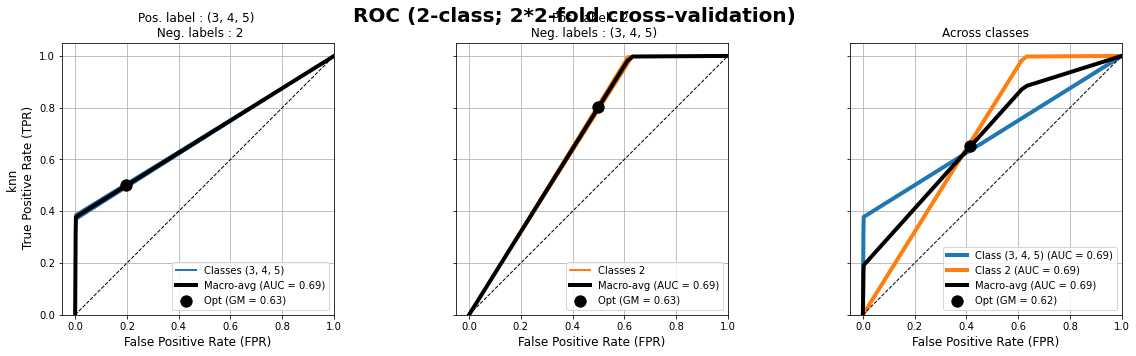

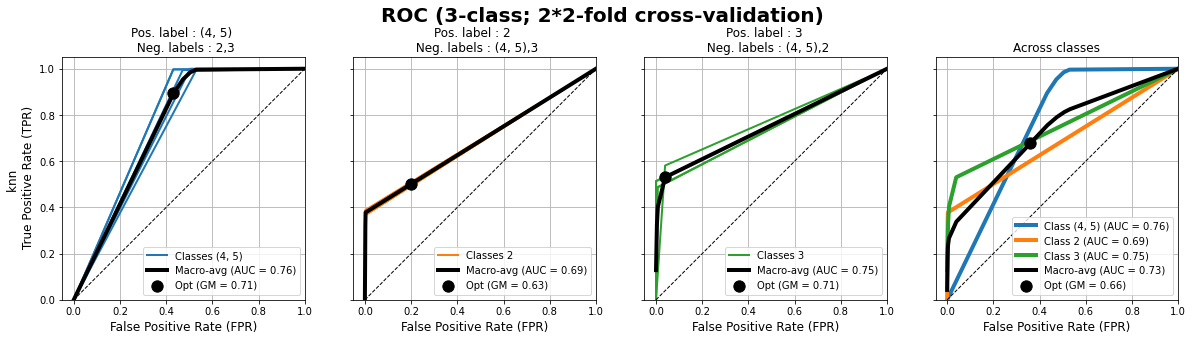

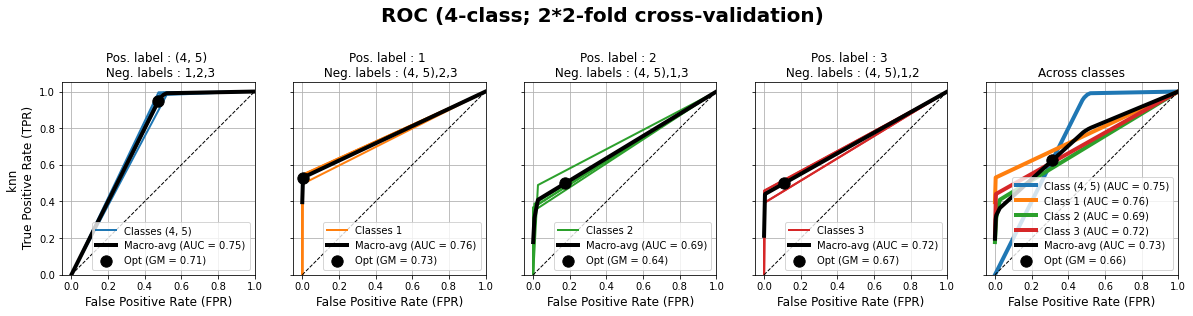

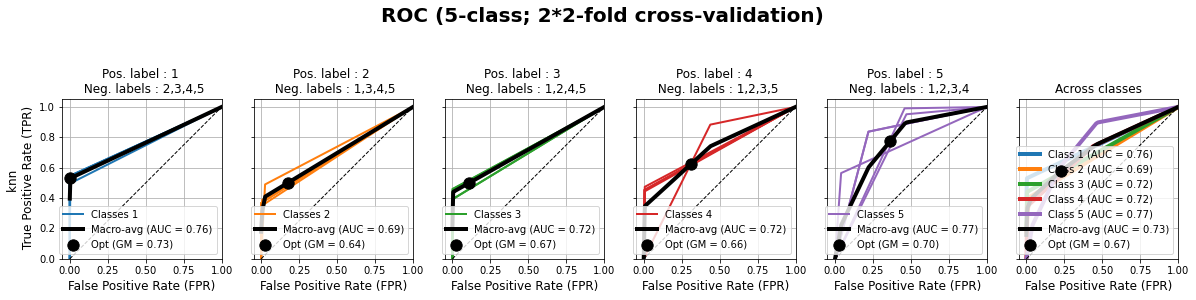

In [16]:
lw = 2 # Line width
fpr_models = []
# for dataCleanedMergedTmp, classTmp, clfName, clf in zip(optDataCleanedMerged, optClass, optClfName, optClf):
for dataCleanedMergedTmp, clfName, clf in zip(optDataCleanedMerged, optClfName, optClf):
#     fpr_model = rocTot_plotter(dataCleanedMergedTmp, reviewColName, ratingColName, ratingOrigColName, clfName, clf, lw, colors_classes)
    fpr_model = rocTot_plotter(dataCleanedMergedTmp, clfName, clf, lw, colors_classes)
    fpr_models.append(fpr_model)

## Macro-averaged ROC comparison across multi-class scenarios, i.e., 2-class, ..., 5-class ([ToC](#TOC))<a class="anchor" id="MacroAveragedROC"></a> 

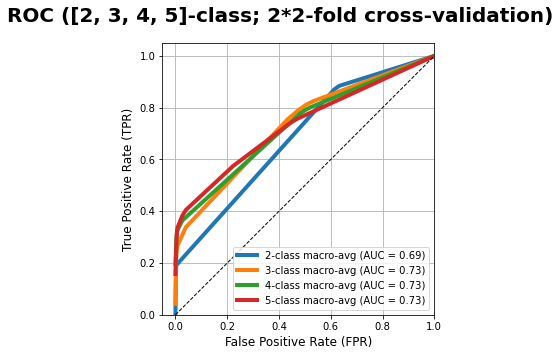

In [17]:
fprIdx, tprIdx, aucIdx = 0, 1, 2
fig, ax = plt.subplots(1, 1, figsize=(20,5))
fig.suptitle('ROC ({}-class; {}*{}-fold cross-validation)'.format(str(nClass), n_repeats, n_splits), #  performance evaluation technique
            fontsize=20, fontweight='bold')  
for i in range(len(fpr_models)):
    ax.plot(fpr_models[i][fprIdx]["macro"], fpr_models[i][tprIdx]["macro"], color=colors_classes[i], lw=2*lw, 
                   label='{0}-class macro-avg (AUC = {1:0.2f})'.format(nClass[i], fpr_models[i][aucIdx]["macro"]))        
rocAxis_plotter(ax, lw, 'True Positive Rate (TPR)')

## Results ([ToC](#TOC))<a class="anchor" id="ROCResults"></a> 

In [18]:
display_markdown('''
* For each multi-class scenario, i.e., 2-class, ..., 5-class, the following procedure is repeated:
    * Multi-class labels are binarised, i.e., One-vs-rest (OvR), and for each binary label vector (the following colour-coded ROCs) following steps are performed:
        1. training/test dataset split using N*K-fold cross-validation (CV)
        1. Model (pipeline: TF-IDF -> SMOTE -> fine-tuned classifier) is trained on the training dataset;
        1. Trained model is scored on the test dataset;
        1. [ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) curve and AUC are computed as an evaluation metric for each CV repetition;
        1. Macro average (single black curve) is computed across CV repetitions (multiple coloured curves);
        1. The threshold maximising the geometric mean (G-mean) of sensitivity and specificity is selected as the optimal threshold (to be used at the next step).
    * Macro-average ROC was computed across binarised cases (last columns), which their AUC is shown below:
     * ||**{}-class**|**{}-class**| **{}-class**| **{}-class**|
       |:---|:---|:----|:----|:----|
       |**Macro-average AUC**|{}|{}|{}|{}|
    '''.format(*nClass,*[round(i[aucIdx]["macro"], 2) for i in fpr_models]), raw=True)


* For each multi-class scenario, i.e., 2-class, ..., 5-class, the following procedure is repeated:
    * Multi-class labels are binarised, i.e., One-vs-rest (OvR), and for each binary label vector (the following colour-coded ROCs) following steps are performed:
        1. training/test dataset split using N*K-fold cross-validation (CV)
        1. Model (pipeline: TF-IDF -> SMOTE -> fine-tuned classifier) is trained on the training dataset;
        1. Trained model is scored on the test dataset;
        1. [ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) curve and AUC are computed as an evaluation metric for each CV repetition;
        1. Macro average (single black curve) is computed across CV repetitions (multiple coloured curves);
        1. The threshold maximising the geometric mean (G-mean) of sensitivity and specificity is selected as the optimal threshold (to be used at the next step).
    * Macro-average ROC was computed across binarised cases (last columns), which their AUC is shown below:
     * ||**2-class**|**3-class**| **4-class**| **5-class**|
       |:---|:---|:----|:----|:----|
       |**Macro-average AUC**|0.69|0.73|0.73|0.73|
    

# Optimal model ([ToC](#TOC))<a class="anchor" id="OptimalModel"></a> 
## Confuison/Error matrix
* The confusion matrix is a performance evaluation technique in a classification task (per-category comparison of the predicted labels to the true labels). 
* The standard/conventional confusion matrix is computed for a binary classification task (Negative and Positive labels).
* Correctly-classified samples are either True Positive or True Negative, while the mis-classified ones are either called False Positive or False Negative.
* Some useful evaluation metrics that can be derived from the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) are:
 * True Positive Rate (TPR), or sensitivity, or recall, or hit rate;
 * Positive Predictive Value (PPV) or precision;
 * F1 score (the harmonic mean of precision and sensitivity);
 * Accuracy (ACC). 

In [19]:
def confusionMatrix_plotter(ax, cf_matrix, classLabel, classLabelTot, origNew, cmap, ylabel=None):
    ax.axis('square')
    cf_dim = len(cf_matrix)
    group_percentages = ['{0:.1%}'.format(value) for value in cf_matrix.ravel() / np.sum(cf_matrix)]
    if cf_dim == 2 and classLabel != None: #OvR
        group_names = ['TN','FP',"FN", 'TP']
        theRestTot = negClass_finder(classLabel, classLabelTot, origNew)
        categories  = [theRestTot, origNew[classLabel]] # group_names = ['b']*(cf_dim**2)
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    else: # Multiclass
        categories = []
        for i in classLabelTot:
            categories.append(origNew[i])
        labels = group_percentages
    labels = np.asarray(labels).reshape(cf_dim, cf_dim)        
#     cmap = colors_classes_CF
    h = sns.heatmap(cf_matrix, ax=ax, annot = labels, cmap = cmap,fmt = '',
                xticklabels = categories, yticklabels = categories, cbar_kws={"shrink": 0.5})
    ax.set_ylim(cf_dim, 0)
    ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')    
    if cf_dim == 2 and classLabel != None:
        tn, fp, fn, tp = cf_matrix.ravel()
        tpr = tp / (tp + fn)
        ppv = tp / (tp + fp)  
        f1 = 2 * (ppv*tpr)/(ppv+tpr)
        acc = (tp + tn) / (tp + tn + fn + fp)
    else: # cf_dim == n_classes:
        acc = np.sum(np.diag(cf_matrix)) / np.sum(cf_matrix)
        tpr = np.nan
        ppv = np.nan 
        f1 = np.nan         
    ax.set_xlabel("Predicted values", fontdict = {'size':12}) #, labelpad = 10
    ax.set_ylabel(ylabel, fontdict = {'size':12}) # , labelpad = 10     
        
    if cf_dim == 2 and classLabel != None: #classLabel != None: # Binary        
        ax.set_title ("Neg. labels: {0} \nPos. label: {1}\nTPR={2:.1%}, PPV={3:.1%}\nF1={4:.1%}, ACC={5:.1%}".
                      format(theRestTot, origNew[classLabel], tpr, ppv, f1, acc), 
                                    fontdict = {'size':12}) # , pad = 20
    else: # Multiclass
        ax.set_title ("Multi-class task\nAcc={0:.2%}".format(acc), fontdict = {'size':12})
    return acc
    

# def split_feature_clf_confusion(X, y, test_size, clf, thr):
def split_feature_clf_confusion(X_train, y_train, X_test, y_test, clf, thr):
    """Splits into train/test; extracts features; trains & tests the classifier. Returns average test confusion matrix."""
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) # train/test split
    model, _ = model_builder(y_train, clf, '')
    model.fit(X_train, y_train)                 
    if len(np.unique(y_train)) == 2: # If binary task  
        y_score = model.predict_proba(X_test)[:, 1]
        if thr == None:
            thr = 0.5
        y_score[y_score >= thr] = 1
        y_score[y_score < thr] = 0
    else:
        y_score = model.predict(X_test)        
    return confusion_matrix(y_test, y_score), classification_report(y_test, y_score, output_dict=True)


# def confusionTot_plotter(fpr_model, optDataCleanedMerged, reviewColName, ratingColName, ratingOrigColName, clfName, clf, colors_classes_CF, dataCleaned_test):
def confusionTot_plotter(fpr_model, optDataCleanedMerged, clfName, clf, colors_classes_CF, dataCleaned_test):    
#     yOrig, X, y = optDataCleanedMerged[ratingOrigColName].values, optDataCleanedMerged[reviewColName].values, optDataCleanedMerged[ratingColName].values
#     X_test, y_test, yOrig_test  = dataCleaned_test[reviewColName].values , dataCleaned_test[ratingColName].values
    yOrig, X, y = optDataCleanedMerged[2].values, optDataCleanedMerged[0].values, optDataCleanedMerged[1].values
    X_test, y_test, yOrig_test  = dataCleaned_test[0].values, dataCleaned_test[1].values, dataCleaned_test[2].values
    origNew = origNewLabel_finder(yOrig, y)
    classLabelTot = list(np.unique(y))    
#     X_binary, Y_binary = output_binariser(X, y, classLabelTot)
    lb = MyLabelBinarizer()
    Y_binary = lb.fit_transform(y)
    Y_test_binary = lb.transform(y_test)
    
    n_classes = len(classLabelTot)    
#     clf = OneVsRestClassifier(clf)
    fig, ax = plt.subplots(1, n_classes+1, figsize=(20,6)) # , sharey=True, sharex=True
    fig.suptitle('{}-class: Confusion matrix for the optimum threshold on the ROC'.format(n_classes), fontsize=20, fontweight='bold') 
    for i, classLabel in enumerate(classLabelTot):
#         thr = fpr_model[aucIdx]["macro_{}BestThrVal".format(i+1)]    
        thr = fpr_model["macro_{}BestThrVal".format(i+1)] 
#         cfMatrix = split_feature_clf_confusion(X_binary[i], Y_binary[i], test_size, clf, thr)
        cfMatrix, _ = split_feature_clf_confusion(X, Y_binary[:, i], X_test, Y_test_binary[:, i], clf, thr)
        if i == 0:
            ylabel = "{} \n Actual values".format(clfName)
        else:
            ylabel = None 
        confusionMatrix_plotter(ax[i], cfMatrix, classLabel, classLabelTot, origNew, colors_classes_CF[i], ylabel) 
#     cfMatrix = split_feature_clf_confusion(X, y, test_size, clf, None)
    cfMatrix, report = split_feature_clf_confusion(X, y, X_test, y_test, clf, None)
    acc = confusionMatrix_plotter(ax[n_classes], cfMatrix, None, classLabelTot, origNew, 'Greys', None)         
    plt.savefig("../working/{}-classConfusion.png".format(n_classes))
    return acc, report

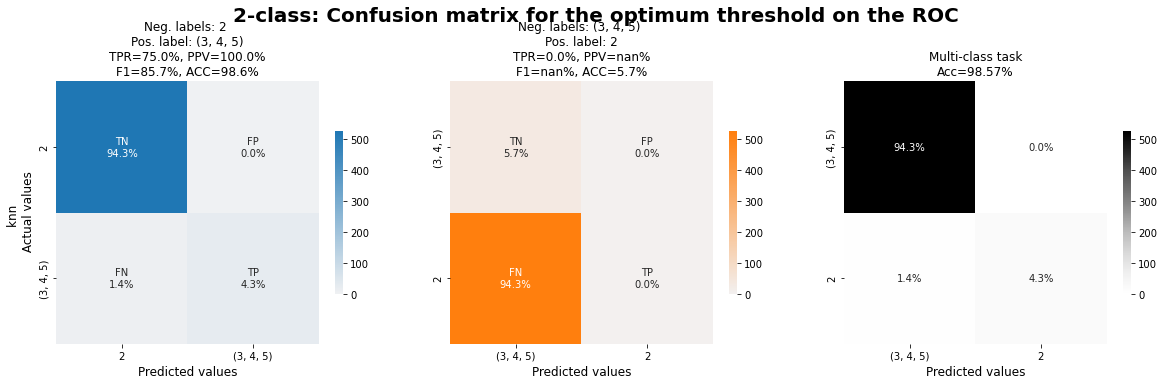

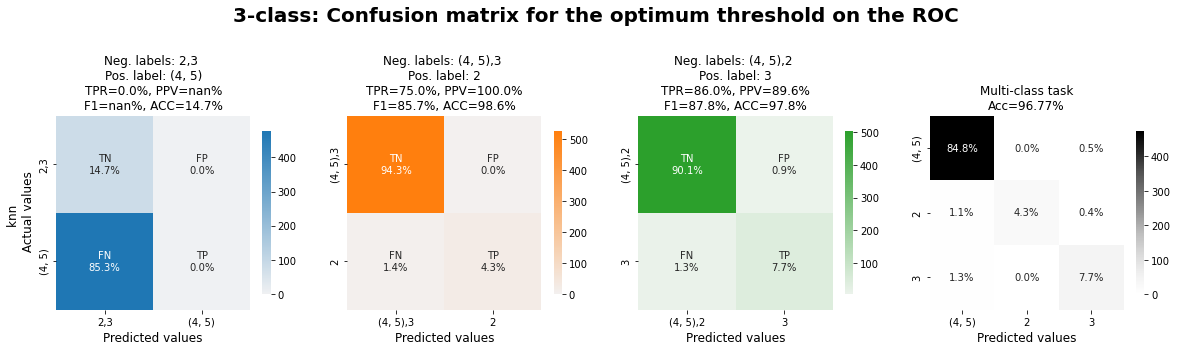

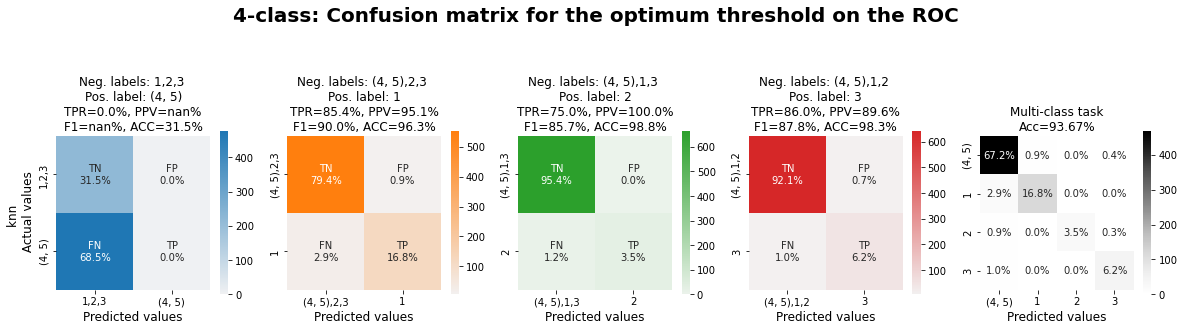

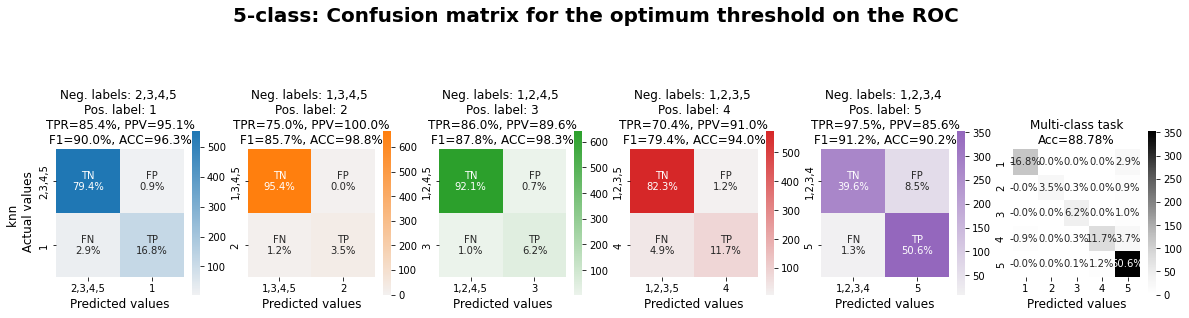

In [20]:
colors_classes_CF = []
for colors_classe in colors_classes:
    colors_classes_CF.append(sns.light_palette(colors_classe, as_cmap=True))
acc = []
report = []
# for fpr_model, dataCleanedMergedTmp, classTmp, clfName, clf, dataCleanedMerged_test_ in zip(fpr_models, optDataCleanedMerged, optClass, optClfName, optClf, dataCleanedMerged_test):
for fpr_model, dataCleanedMergedTmp, clfName, clf, dataCleanedMerged_test_ in zip(fpr_models, optDataCleanedMerged, optClfName, optClf, yMerged_test):
#     acc_ = confusionTot_plotter(fpr_model[aucIdx], dataCleanedMergedTmp, reviewColName, ratingColName, ratingOrigColName, clfName, clf, colors_classes_CF, dataCleanedMerged_test_)
    acc_, report_ = confusionTot_plotter(fpr_model[aucIdx], dataCleanedMergedTmp, clfName, clf, colors_classes_CF, dataCleanedMerged_test_)
    acc.append(acc_)
    report.append(report_)

## Results ([ToC](#TOC))<a class="anchor" id="OptimalModelResults"></a> 

In [21]:
display_markdown('''
* For each multi-class scenario, i.e., 2-class, ..., 5-class, the following procedure is repeated:
    * Multi-class labels are binarised, i.e., One-vs-rest (OvR), and for each binary label vector (the following colour-coded confusion matrices) following steps are performed:
        1. Model (pipeline: TF-IDF -> SMOTE -> fine-tuned classifier) is trained on the training dataset;
        1. Trained model is scored on the test dataset;
        1. The scores are thresholded based on the optimal threshold obtained from the corresponding ROC;
        1. Confusion matrix is computed as an evaluation metric.
    * The above steps, except for the third step, i.e., scores thresholding, are also repeated for the multi-class task (the grey-coded confusion matrix), which their accuracy is shown below.
     * | N-class |Multi-class ACC|
       |:---|----:|
       | **{0}**  |  **{4}**  |
       | **{1}**| **{5}**  |
       | **{2}**|  **{6}**  |
       | **{3}**|  **{7}**  |
    '''.format(nClass[0], nClass[1], nClass[2], nClass[3],
              round(acc[0], 2), round(acc[1], 2), round(acc[2], 2), round(acc[3], 2)), raw=True)



* For each multi-class scenario, i.e., 2-class, ..., 5-class, the following procedure is repeated:
    * Multi-class labels are binarised, i.e., One-vs-rest (OvR), and for each binary label vector (the following colour-coded confusion matrices) following steps are performed:
        1. Model (pipeline: TF-IDF -> SMOTE -> fine-tuned classifier) is trained on the training dataset;
        1. Trained model is scored on the test dataset;
        1. The scores are thresholded based on the optimal threshold obtained from the corresponding ROC;
        1. Confusion matrix is computed as an evaluation metric.
    * The above steps, except for the third step, i.e., scores thresholding, are also repeated for the multi-class task (the grey-coded confusion matrix), which their accuracy is shown below.
     * | N-class |Multi-class ACC|
       |:---|----:|
       | **2**  |  **0.99**  |
       | **3**| **0.97**  |
       | **4**|  **0.94**  |
       | **5**|  **0.89**  |
    

In [22]:
# classification_report(report[0])

# References ([ToC](#TOC))<a class="anchor" id="References"></a> 
* [Tune Hyperparameters for Classification Machine Learning Algorithms](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)
* [Tune Hyperparameters with GridSearchCV](https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/)
* [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
* [Caret List of Algorithms and Tuning Parameters](https://topepo.github.io/caret/available-models.html)
* [Python equivalent of MATLAB's "ismember" function](https://devpress.csdn.net/python/630459aac67703293080ba45.html)
* [python: how to identify if a variable is an array or a scalar](https://stackoverflow.com/questions/16807011/python-how-to-identify-if-a-variable-is-an-array-or-a-scalar)
* [MATLAB ind2sub equivalent in Python](https://stackoverflow.com/questions/28995146/matlab-ind2sub-equivalent-in-python)
* [sklearn LabelBinarizer returns vector when there are 2 classes](https://stackoverflow.com/questions/31947140/sklearn-labelbinarizer-returns-vector-when-there-are-2-classes)
* [A Gentle Introduction to Threshold-Moving for Imbalanced Classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)
* [Naive Bayes Classifier in Python](https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python)
* [Naive Bayes Classifier From Scratch in Python](https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/)
* [imbalanced-learn documentation](https://imbalanced-learn.org/stable/)
* [SMOTE: Synthetic Minority Over-sampling Technique](https://www.jair.org/index.php/jair/article/view/10302)
* [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* [The optimality of Naive Bayes](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf)
* [Performance Comparison of Tuned and Untuned Classification Models](https://www.analyticsvidhya.com/blog/2021/06/performance-comparision-of-tuned-and-untuned-classification-models/)
* [Multiclass Receiver Operating Characteristic (ROC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
